## Логистическая регрессия

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

Реализуйте обучение логистической регрессии с $L^1$ и $L^2$ регуляризацией с помощью метода Stochastic Gradient Descent (SGD)

#### Замечания
* В SGD градиент расчитывается по одному случайному объекту
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в выборке (тем или иным способом)

# Реализация модели

In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin
from math import log2, exp


class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=100, alpha=0.01, max_epoch=10, penalty='l2'):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self._penalty = penalty
        
        self.epsilon = 0.001
        
        self.all_Q = []
  
    @property
    def R(self):
        return (1.0 / (1 + self.C))
    
    @staticmethod
    def sigma(t): 
        return 1 / (1 + exp(-1 * t))
    
    def penalty(self, weight):
        if self._penalty == 'l1':
            return self.R * (1 if weight >= 0 else -1)
        elif self._penalty == 'l2':
            return 2 * self.R * weight
        else:
            raise NotImplementedError('penalty method {} not found'.format(self._penalty))

    def Q(self, X, theta, y):
        n = y.shape[0]
        p = np.vectorize(self.sigma)(X @ theta)
        one = np.ones(n)
        log = np.vectorize(log2)
        
        return (-1.0/n) * (y * log(p) + (one - y) * log(one - p)).sum()
        
    def grad_Q(self, X, theta, y):
        n = X.shape[0]
        k = theta.shape[0] - 1
        
        sigma = np.vectorize(self.sigma)
        penalty = np.vectorize(self.penalty)

        return np.hstack([(1.0/n)*((sigma(X @ theta) - y)), 1]) @ np.vstack([X, penalty(theta)])
            
    def fit(self, X, y):
        '''
        Обучение модели
        '''

        self.all_Q = []
        self.QS = []
        
        n = X.shape[0]
        k = X.shape[1]
        
        theta = np.random.random(k+1)
        X_ = np.hstack([X, np.ones(n).reshape([n, 1])])
        
        Q_ = None
        new_theta = theta
        
        for epoch in range(self.max_epoch):
            Q_ = self.Q(X_, theta, y)
            self.all_Q.append(Q_)

            for idx in np.random.permutation(np.arange(n)):
                theta = new_theta

                new_theta = theta - self.alpha * self.grad_Q(X_[idx:idx+1], theta, y[idx:idx+1])

                if np.linalg.norm(theta - new_theta) < self.epsilon: 
                    break            

        self.theta = theta
        self.last_Q = Q_
        
        return self

    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        
        X_ = np.hstack([X, np.ones(X.shape[0]).reshape([X.shape[0], 1])])
        y_hat = [0 if y_i < 0.5 else 1 for y_i in (X_ @ self.theta)]
        
        return y_hat
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''

        X_ = np.hstack([X, np.ones(X.shape[0]).reshape([X.shape[0], 1])])
        y_hat_proba = [sigma(y_i) for y_i in (X_ @ self.theta)]
        
        return y_hat_proba


## Проверка на синтетических данных (2 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

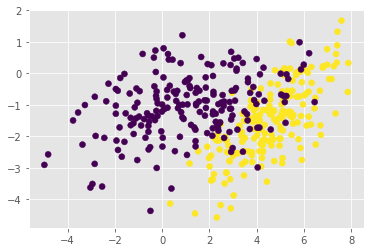

In [3]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y)

In [4]:
model = MySGDClassifier()
model.fit(X, y)
0

0

'Theta'

array([ 0.53023289, -0.27400763, -1.50936325])

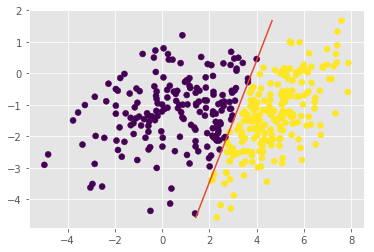

In [5]:
y_pred = model.predict(X)

def to_x1(x2):
    return +(-1*model.theta[1]*x2)/model.theta[0] + (0.5-1*model.theta[2])/model.theta[0]

def to_x2(x1):
    return +(-1*model.theta[0]*x1)/model.theta[1] + (0.5-1*model.theta[2])/model.theta[1]

if abs(model.theta[0]) > 1:
    points = np.array([
        [X[:, 0].min(), X[:, 0].max()],
        [to_x2(X[:, 0].min()), to_x2(X[:, 0].min())],
    ])
else:
    points = np.array([
        [to_x1(X[:, 1].min()), to_x1(X[:, 1].max())],
        [X[:, 1].min(), X[:, 1].max()]
    ])

plt.scatter(X[:,0], X[:,1], c=y_pred)
plt.plot(points[0], points[1])

display('Theta', model.theta)

## Анализ сходимости

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/эпохи (выбрать одно) для разных `alpha`.

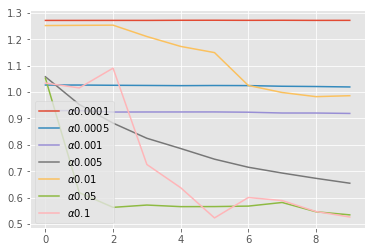

In [6]:
alpha_values = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]

for alpha in alpha_values:
    model = MySGDClassifier(alpha=alpha)
    model.fit(X, y)
    plt.plot(range(len(model.all_Q)), model.all_Q, label=r'$\alpha {}$'.format(alpha))

plt.legend()